<a href="https://colab.research.google.com/github/zodbot/llm_finetuning/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluating Fine-tuned GPT-2 Sentiment Classifier

This notebook:
1. Loads previously fine-tuned GPT-2 model
2. Evaluates performance on test set
3. Provides function for classifying new reviews
4. Demonstrates usage with example reviews

Model details:
- Base: GPT-2 fine-tuned on SST-2
- Task: Binary sentiment classification
- Output: Positive/Negative with confidence scores

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7d4ea50d2b50>)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M",
    models_dir="/content/drive/MyDrive/gpt2"
)

Mounted at /content/drive
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/checkpoint
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/encoder.json
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/hparams.json
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: /content/drive/MyDrive/gpt2/124M/vocab.bpe


In [22]:
import sys


!git clone https://github.com/zodbot/llm_finetuning.git

# Change into repo directory
%cd llm_finetuning

from src.model import GPTModel
from src.config import GPT_CONFIGS
from src.utils import load_weights_into_gpt
import torch

# Get configuration
config = GPT_CONFIGS["gpt2-small (124M)"]

# Set up model for classification
model = GPTModel(config)
load_weights_into_gpt(model, params)
model.eval()

# Freeze model
for param in model.parameters():
    param.requires_grad = False

# Modify for classification
num_classes = 2
model.out_head = torch.nn.Linear(config["emb_dim"], num_classes)
# model.out_head = torch.nn.Sequential(
#     torch.nn.Dropout(0.3),
#     torch.nn.Linear(config["emb_dim"], num_classes)
# )
# Unfreeze specific layers
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

Cloning into 'llm_finetuning'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 54 (delta 16), reused 41 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 32.45 KiB | 1.80 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/llm_finetuning/llm_finetuning/llm_finetuning/llm_finetuning


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00


In [3]:
# SST-2 (Stanford Sentiment Treebank) is a great dataset for binary sentiment classification
from datasets import load_dataset
ds = load_dataset('nyu-mll/glue', 'sst2', split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [4]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.5 MB/s eta 0:00:00


In [5]:
# Convert to pandas DataFrame
import pandas as pd
import tiktoken

df = pd.DataFrame({
    'Label': ds['label'],
    'Text': ds['sentence']
})
tokenizer = tiktoken.get_encoding("gpt2")
print(len(df))
print(df["Label"].value_counts())

# Take random sample of 1000 rows
df_sample = df.sample(n=5000, random_state=42)  # random_state for reproducibility

# Optional: Look at the distribution of labels to ensure it's balanced
print("Label distribution in sample:")
print(df_sample['Label'].value_counts())

def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

f = open("train.csv")
inputs = []
max_length = 0
for line in f.read():
  ids = tokenizer.encode(line)
  max_length = max(max_length, len(ids))
  inputs.append(ids)


for input in inputs:
  for _ in range(max_length - len(input)):
    input.append(5027)



67349
Label
1    37569
0    29780
Name: count, dtype: int64
Label distribution in sample:
Label
1    2833
0    2167
Name: count, dtype: int64


In [6]:
import torch
from torch.utils.data import Dataset
# it identifies the longest sequence in the training dataset, encodes the text messages,
# and ensures that all other sequences are padded with a padding token to match the length of the longest sequence.
class Sst2DataSet(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
      self.data = pd.read_csv(csv_file)
      self.encoded_texts = [tokenizer.encode(data) for data in self.data["Text"]]
      if max_length is None:
          self.max_length = self._longest_length()
      else:
          self.max_length = max_length
      # Truncates sequences if they are longer than max_length
      self.encoded_texts = [
                  encoded_text[:self.max_length]
                  for encoded_text in self.encoded_texts
      ]
      # add padding
      self.encoded_texts = [
        encoded_text + [pad_token_id] *
        (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
      ]


  def __getitem__(self, index):
      encoded = self.encoded_texts[index]
      label = self.data.iloc[index]["Label"]
      return (
          torch.tensor(encoded, dtype=torch.long),
          torch.tensor(label, dtype=torch.long)
      )
  def __len__(self):
      return len(self.data)

  def _longest_length(self):
      max_length = 0
      for encoded_text in self.encoded_texts:
          encoded_length = len(encoded_text)
          if encoded_length > max_length:
              max_length = encoded_length
      return max_length


train_dataset = Sst2DataSet(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = Sst2DataSet(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = Sst2DataSet(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

65


In [7]:
import torch


from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
print("# of batches: ", len(train_loader))
for train, target in train_loader:
  print(train.shape, target.shape)
  break


# of batches:  5893
torch.Size([8, 65]) torch.Size([8])


In [8]:
def calc_accuracy(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if not num_batches:
      return
    model.eval()
    for i, (input_batch, target_batch) in enumerate(data_loader):
      if i < num_batches:
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        with torch.no_grad():
          output = model(input_batch)
        output = output[:, -1, :]
        result = torch.argmax(output, -1)
        correct_predictions += sum(predicted == target_batch[i] for i, predicted in enumerate(result))
        num_examples += output.shape[0]

    return correct_predictions / num_examples


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# torch.manual_seed(123)
# train_accuracy = calc_accuracy(
#     train_loader, model, device, num_batches=10
# )
# val_accuracy = calc_accuracy(
#     val_loader, model, device, num_batches=10
# )
# test_accuracy = calc_accuracy(
#     test_loader, model, device, num_batches=10
# )
# print(f"Training accuracy: {train_accuracy*100:.2f}%")
# print(f"Validation accuracy: {val_accuracy*100:.2f}%")
# print(f"Test accuracy: {test_accuracy*100:.2f}%")

In [18]:
def calc_loss(data_loader, model, device, num_batches=None):
  if len(data_loader) == 0:
    return float("nan")

  if num_batches is None:
    num_batches = len(data_loader)

  model.eval()

  all_loss = 0

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        predicted = model(input_batch)
      # we only care about the last token
      predicted = predicted[:, -1, :]
      loss = torch.nn.functional.cross_entropy(predicted, target_batch)
      all_loss += loss.item()
    else:
      break

  return all_loss / num_batches

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
      train_loss = calc_loss(
            train_loader, model, device, num_batches=eval_iter
        )
      val_loss = calc_loss(
            val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_classifier(model, data_loader, val_loader, optimizer, device,
               epoch_num, eval_freq, eval_iter):
  model.train()
  examples_seen = 0
  steps = -1
  train_losses, val_losses, train_accs, val_accs = [], [], [], []

  for epoch in range(epoch_num):
    model.train()
    for i, (input_batch, target_batch) in enumerate(data_loader):
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)
      # reset optimizer
      optimizer.zero_grad()

      loss = calc_loss_batch(input_batch, target_batch, model, device)

      # cal loss gradient
      loss.backward()

      # update weight
      optimizer.step()
      # we care about number of smples not tokens here
      examples_seen += input_batch.shape[0]
      steps += 1

      if steps % eval_freq == 0:
          train_loss, val_loss = evaluate_model(
            model, data_loader, val_loader, device, eval_iter)
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          print(f"Ep {epoch+1} (Step {steps:06d}): "
                f"Train loss {train_loss:.3f}, "
                f"Val loss {val_loss:.3f}")

    train_accuracy = calc_accuracy(
      data_loader, model, device, num_batches=eval_iter
    )
    val_accuracy = calc_accuracy(
      val_loader, model, device, num_batches=eval_iter
    )
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

  return train_losses, val_losses, train_accs, val_accs, examples_seen


In [30]:
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq=2000,
        eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

cuda
Ep 1 (Step 000000): Train loss 4.547, Val loss 5.125
Ep 1 (Step 002000): Train loss 0.425, Val loss 0.545
Ep 1 (Step 004000): Train loss 0.270, Val loss 0.500
Training accuracy: 87.50% | Validation accuracy: 75.00%
Ep 2 (Step 006000): Train loss 0.292, Val loss 0.591
Ep 2 (Step 008000): Train loss 0.177, Val loss 0.552
Ep 2 (Step 010000): Train loss 0.353, Val loss 0.522
Training accuracy: 85.00% | Validation accuracy: 75.00%
Ep 3 (Step 012000): Train loss 0.273, Val loss 0.511
Ep 3 (Step 014000): Train loss 0.431, Val loss 0.503
Ep 3 (Step 016000): Train loss 0.461, Val loss 0.492
Training accuracy: 82.50% | Validation accuracy: 72.50%
Ep 4 (Step 018000): Train loss 0.221, Val loss 0.516
Ep 4 (Step 020000): Train loss 0.357, Val loss 0.529
Ep 4 (Step 022000): Train loss 0.114, Val loss 0.465
Training accuracy: 95.00% | Validation accuracy: 80.00%
Ep 5 (Step 024000): Train loss 0.342, Val loss 0.423
Ep 5 (Step 026000): Train loss 0.175, Val loss 0.434
Ep 5 (Step 028000): Train los

In [31]:
# changed the weight decay
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq=2000,
        eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")



cuda
Ep 1 (Step 000000): Train loss 0.181, Val loss 0.433
Ep 1 (Step 002000): Train loss 0.265, Val loss 0.324
Ep 1 (Step 004000): Train loss 0.176, Val loss 0.336
Training accuracy: 92.50% | Validation accuracy: 82.50%
Ep 2 (Step 006000): Train loss 0.194, Val loss 0.408
Ep 2 (Step 008000): Train loss 0.136, Val loss 0.382
Ep 2 (Step 010000): Train loss 0.194, Val loss 0.416
Training accuracy: 87.50% | Validation accuracy: 80.00%
Ep 3 (Step 012000): Train loss 0.192, Val loss 0.341
Ep 3 (Step 014000): Train loss 0.202, Val loss 0.309
Ep 3 (Step 016000): Train loss 0.325, Val loss 0.345
Training accuracy: 90.00% | Validation accuracy: 85.00%
Ep 4 (Step 018000): Train loss 0.171, Val loss 0.362
Ep 4 (Step 020000): Train loss 0.329, Val loss 0.379
Ep 4 (Step 022000): Train loss 0.086, Val loss 0.321
Training accuracy: 92.50% | Validation accuracy: 85.00%
Ep 5 (Step 024000): Train loss 0.303, Val loss 0.287
Ep 5 (Step 026000): Train loss 0.103, Val loss 0.303
Ep 5 (Step 028000): Train los

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': config,
    'unfrozen_layers': ['trf_blocks[-1]', 'final_norm']  # document which layers were unfrozen
}, '/content/drive/MyDrive/gpt2_finetuned_sst.pt')

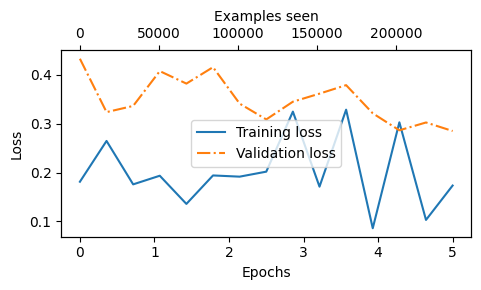

In [36]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
  label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(
  epochs_seen, val_values, linestyle="-.",
      label=f"Validation {label}"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")

  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [1]:
import sys
import torch
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_state = torch.load('/content/drive/MyDrive/gpt2_finetuned_sst.pt',
                         map_location=device)

!git clone https://github.com/zodbot/llm_finetuning.git

# Change into repo directory
%cd llm_finetuning

from src.model import GPTModel
from src.config import GPT_CONFIGS
from src.utils import load_weights_into_gpt
import torch

# Get configuration
config = GPT_CONFIGS["gpt2-small (124M)"]

model = GPTModel(config)

# 2. Modify model architecture for classification (just like during training)
num_classes = 2
model.out_head = torch.nn.Linear(config["emb_dim"], num_classes)

# load the state dict
model.load_state_dict(loaded_state['model_state_dict'])


Mounted at /content/drive


<ipython-input-1-25c9850208b1>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state = torch.load('/content/drive/MyDrive/gpt2_finetuned_sst.pt',


Cloning into 'llm_finetuning'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 54 (delta 16), reused 41 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 32.45 KiB | 4.63 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/llm_finetuning


<All keys matched successfully>

In [13]:
def calc_accuracy(data_loader, model, device, num_batches=None):
    if len(data_loader) == 0:
        return float("nan")

    if num_batches is None:
        num_batches = len(data_loader)

    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            # Forward pass
            outputs = model(input_batch)
            outputs = outputs[:, -1, :]  # Get last token predictions
            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy
            total += target_batch.size(0)
            correct += (predicted == target_batch).sum().item()

    accuracy = correct / total if total > 0 else 0
    return accuracy  # Make sure we return the accuracy!

train_accuracy = calc_accuracy(train_loader, model, device, 4)
val_accuracy = calc_accuracy(val_loader, model, device, 4)
test_accuracy = calc_accuracy(test_loader, model, device, 4)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 96.88%
Validation accuracy: 87.50%
Test accuracy: 93.75%


In [14]:
def text_to_token_ids(text, tokenizer, max_length=None, pad_token_id=50256):
    # Encode text to token IDs
    tokens = tokenizer.encode(text)

    # Convert to tensor and add batch dimension
    tokens = torch.tensor(tokens).unsqueeze(0)  # Add batch dimension

    # Handle max length if specified
    if max_length is not None:
        if tokens.size(1) > max_length:
            # Truncate if too long
            tokens = tokens[:, :max_length]
        elif tokens.size(1) < max_length:
            # Pad if too short
            padding = torch.full((1, max_length - tokens.size(1)),
                               pad_token_id,
                               dtype=torch.long)
            tokens = torch.cat([tokens, padding], dim=1)

    return tokens

# Example usage:
# text = "This is a great movie!"
# token_ids = text_to_token_ids(text, tokenizer, max_length=512)
# print(token_ids.shape)  # Should be [1, sequence_length]
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    with torch.no_grad():
        # Tokenize the input text
        tokens = text_to_token_ids(text, tokenizer).to(device)

        # Get model prediction
        logits = model(tokens)
        logits = logits[:, -1, :]  # Get last token's logits

        # Convert to probabilities
        probs = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(probs, dim=-1).item()
        confidence = probs[0, prediction].item()

        # Convert to sentiment
        sentiment = "Positive" if prediction == 1 else "Negative"

        return {
            "sentiment": sentiment,
            "confidence": confidence,
            "probabilities": {
                "negative": probs[0, 0].item(),
                "positive": probs[0, 1].item()
            }
        }

# Example usage:
test_reviews = [
    "This movie was absolutely fantastic!",
    "What a terrible waste of time.",
    "The acting was okay, but the plot was confusing."
]

for review in test_reviews:
    result = classify_review(review, model, tokenizer, device)
    print(f"\nReview: {review}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilities: Positive: {result['probabilities']['positive']:.2%}, "
          f"Negative: {result['probabilities']['negative']:.2%}")


Review: This movie was absolutely fantastic!
Sentiment: Positive
Confidence: 99.49%
Probabilities: Positive: 99.49%, Negative: 0.51%

Review: What a terrible waste of time.
Sentiment: Negative
Confidence: 86.95%
Probabilities: Positive: 13.05%, Negative: 86.95%

Review: The acting was okay, but the plot was confusing.
Sentiment: Negative
Confidence: 61.85%
Probabilities: Positive: 38.15%, Negative: 61.85%
